In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Astrometric fitting

In this tutorial we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements. For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract).

In [3]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(
    dirname + "astro.txt", format="csv", fill_values=[(".", "0")]
)

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping
# the primary and secondary star
ind = (
    (astro_dates.value > 1975.0)
    & (astro_dates.value < 1999.73)
    & (~astro_data_full["rho"].mask)
    & (~astro_data_full["PA"].mask)
)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = "jd"
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01^{\prime\prime}$ in separation for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [4]:
import numpy as np

astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float)  # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi / 180.0
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float)
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg)  # radians

## Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit.

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

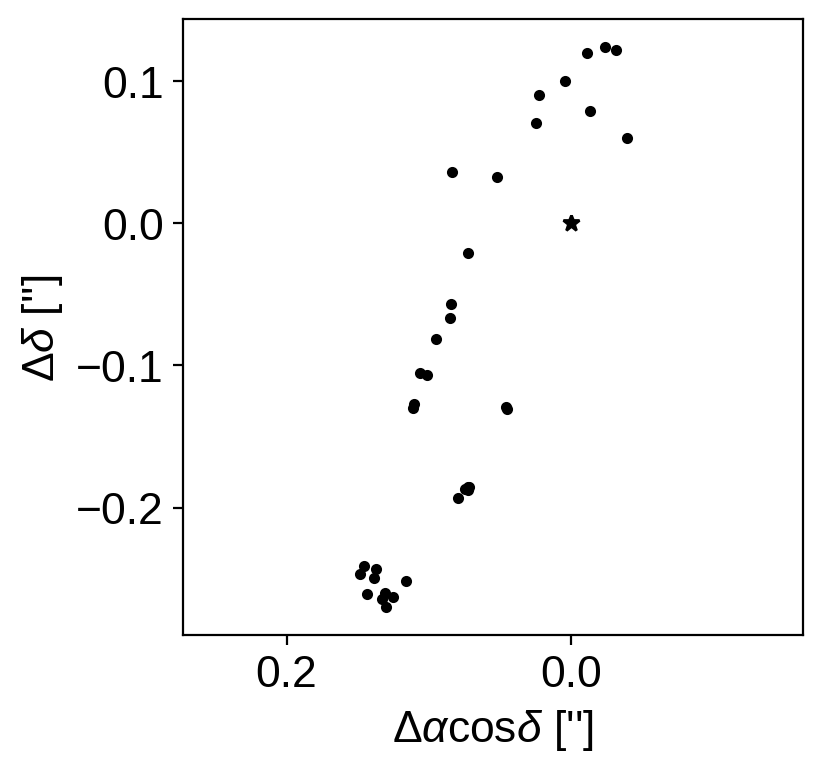

In [5]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

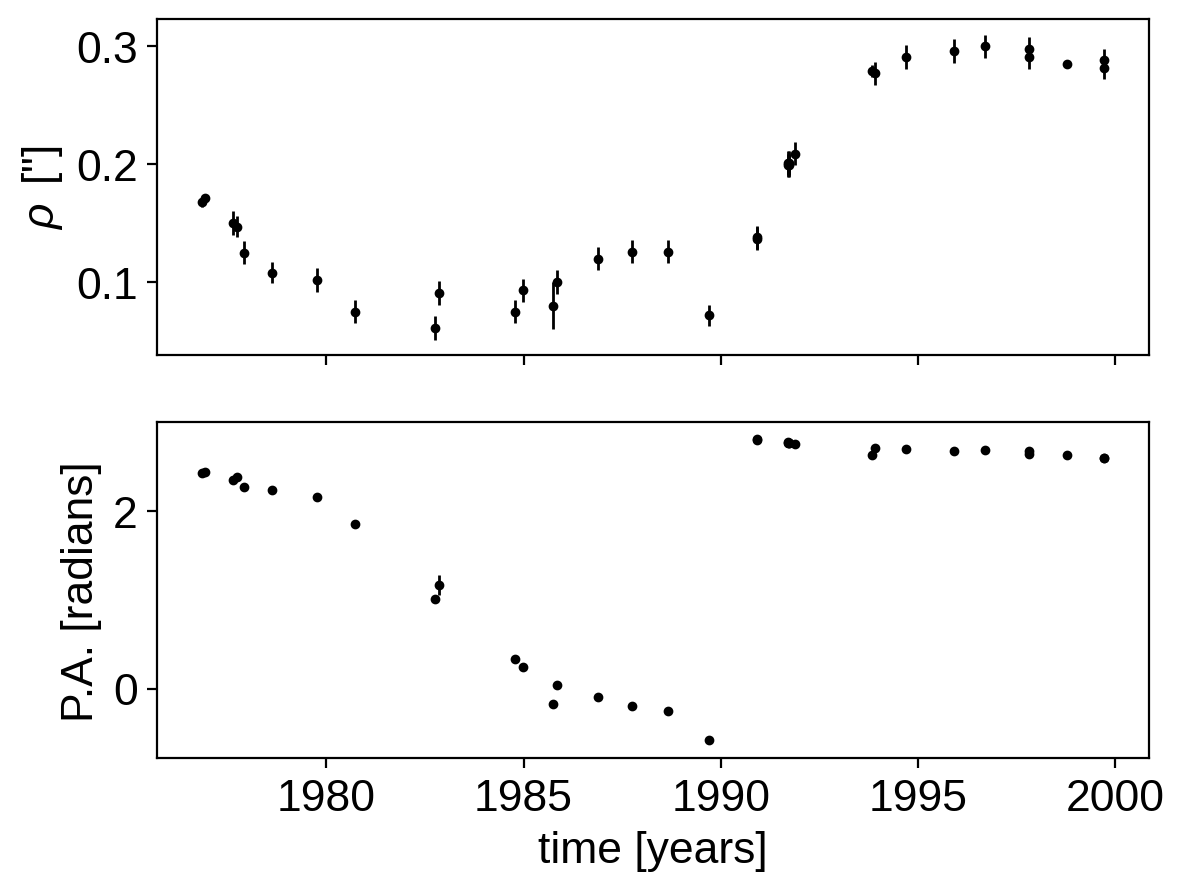

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [years]")

## Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

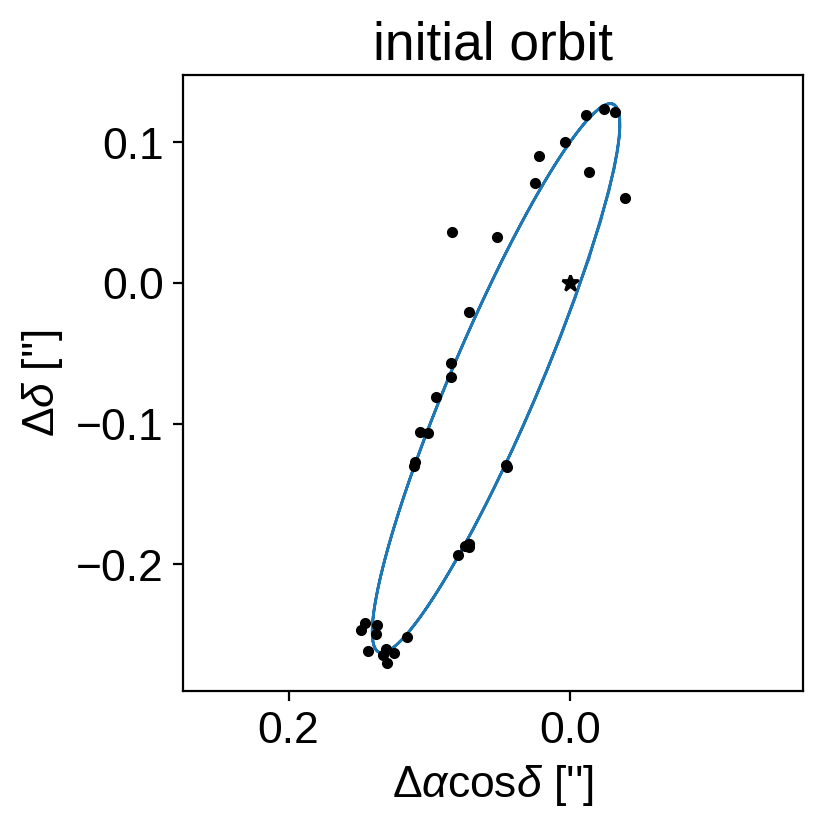

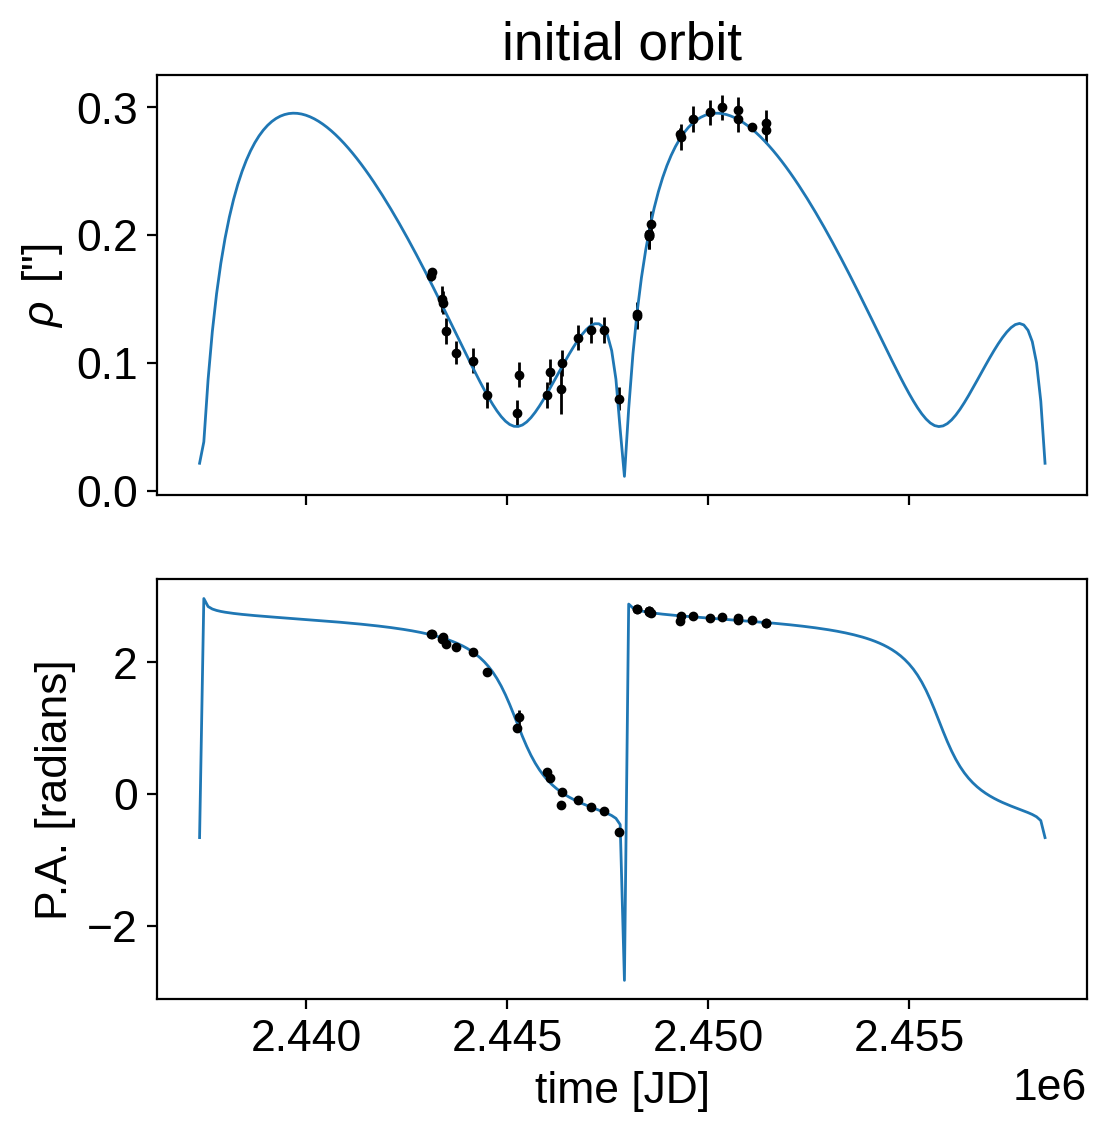

In [7]:
import pymc3 as pm
import theano
import theano.tensor as tt

import exoplanet as xo
from exoplanet.distributions import Angle

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324  # arcsec
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg  # [rad]
omega = 251.6 * deg - np.pi  # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg
P = 28.8 * 365.25  # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega
)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t = np.linspace(T0 - P, T0 + P, num=200)  # days
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit")

ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [JD]")

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

In [8]:
yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)


def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)

        a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years,
        # so we'll set a broad prior on logP
        logP = pm.Normal(
            "logP", mu=np.log(25 * yr), sd=10.0, testval=np.log(28.8 * yr)
        )
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = 251.6 * deg - np.pi
        Omega0 = 159.6 * deg
        p = Angle("p", testval=0.5 * (Omega0 + omega0))
        m = Angle("m", testval=0.5 * (Omega0 - omega0))
        omega = pm.Deterministic("omega", p - m)
        Omega = pm.Deterministic("Omega", p + m)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2 * np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1, testval=np.cos(96.0 * deg)
        )
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.798)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun,
            t_periastron=tperi,
            period=P,
            incl=incl,
            ecc=ecc,
            omega=omega,
            Omega=Omega,
        )
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal(
            "log_rho_s", mu=np.log(np.median(rho_err)), sd=5.0
        )
        log_theta_s = pm.Normal(
            "log_theta_s", mu=np.log(np.median(theta_err)), sd=5.0
        )
        rho_tot_err = tt.sqrt(rho_err ** 2 + tt.exp(2 * log_rho_s))
        theta_tot_err = tt.sqrt(theta_err ** 2 + tt.exp(2 * log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(
            tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data)
        )
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = xo.optimize(map_soln, vars=[phase])
        map_soln = xo.optimize(map_soln, vars=[p, m, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)

    return model, map_soln


model, map_soln = get_model()

optimizing logp for variables: [log_theta_s, log_rho_s]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.048555e+02]

1it [00:00, 412.95it/s, logp=1.048555e+02]

2it [00:00, 468.06it/s, logp=1.448865e+02]

3it [00:00, 550.22it/s, logp=1.056457e+02]

4it [00:00, 632.65it/s, logp=1.457994e+02]

5it [00:00, 683.00it/s, logp=1.469999e+02]

6it [00:00, 722.89it/s, logp=1.471434e+02]

7it [00:00, 716.89it/s, logp=1.471440e+02]

8it [00:00, 734.33it/s, logp=1.471440e+02]

9it [00:00, 740.11it/s, logp=1.471440e+02]

10it [00:03,  2.65it/s, logp=1.471440e+02]


message: Optimization terminated successfully.
logp: 104.85554109304441 -> 147.14399186005338


optimizing logp for variables: [phase]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.471440e+02]

1it [00:00, 398.89it/s, logp=1.471440e+02]

2it [00:00, 523.67it/s, logp=-1.185831e+04]

3it [00:00, 628.42it/s, logp=1.471671e+02] 

4it [00:00, 652.76it/s, logp=1.472136e+02]

5it [00:00, 707.64it/s, logp=1.473986e+02]

6it [00:00, 759.08it/s, logp=1.481189e+02]

7it [00:00, 798.83it/s, logp=1.507231e+02]

8it [00:00, 813.15it/s, logp=1.565965e+02]

9it [00:00, 834.10it/s, logp=1.634911e+02]

10it [00:00, 839.77it/s, logp=1.666396e+02]

11it [00:00, 850.14it/s, logp=1.675455e+02]

12it [00:00, 859.44it/s, logp=1.676215e+02]

13it [00:00, 866.80it/s, logp=1.676248e+02]

14it [00:00, 821.96it/s, logp=1.676282e+02]

15it [00:00, 823.87it/s, logp=1.676337e+02]

16it [00:00, 826.32it/s, logp=1.676403e+02]

17it [00:00, 836.75it/s, logp=1.676419e+02]

18it [00:00, 843.22it/s, logp=1.676422e+02]

19it [00:00, 847.33it/s, logp=1.676422e+02]

20it [00:00, 838.17it/s, logp=1.676422e+02]

21it [00:00, 845.81it/s, logp=1.676422e+02]

22it [00:01, 21.80it/s, logp=1.676422e+02] 


message: Optimization terminated successfully.
logp: 147.14399186005338 -> 167.64220598197195


optimizing logp for variables: [ecc, m, p]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.676422e+02]

1it [00:00, 366.67it/s, logp=1.676422e+02]

2it [00:00, 448.73it/s, logp=-4.521021e+03]

3it [00:00, 564.26it/s, logp=1.682354e+02] 

4it [00:00, 613.36it/s, logp=1.667490e+02]

5it [00:00, 665.21it/s, logp=1.683674e+02]

6it [00:00, 691.14it/s, logp=1.686220e+02]

7it [00:00, 730.95it/s, logp=1.694033e+02]

8it [00:00, 750.27it/s, logp=1.714304e+02]

9it [00:00, 733.24it/s, logp=1.784310e+02]

10it [00:00, 736.66it/s, logp=1.921973e+02]

11it [00:00, 749.51it/s, logp=1.936845e+02]

12it [00:00, 748.74it/s, logp=1.964254e+02]

13it [00:00, 758.38it/s, logp=2.010939e+02]

14it [00:00, 763.12it/s, logp=2.074741e+02]

15it [00:00, 768.74it/s, logp=2.094264e+02]

16it [00:00, 778.81it/s, logp=2.098562e+02]

17it [00:00, 788.20it/s, logp=2.098999e+02]

18it [00:00, 785.76it/s, logp=2.099152e+02]

19it [00:00, 789.45it/s, logp=2.099416e+02]

20it [00:00, 797.43it/s, logp=2.099853e+02]

21it [00:00, 803.50it/s, logp=2.100398e+02]

22it [00:00, 800.74it/s, logp=2.100552e+02]

23it [00:00, 803.59it/s, logp=2.100609e+02]

24it [00:00, 806.71it/s, logp=2.100614e+02]

25it [00:00, 812.23it/s, logp=2.100617e+02]

26it [00:00, 815.38it/s, logp=2.100622e+02]

27it [00:00, 820.52it/s, logp=2.100629e+02]

28it [00:00, 825.10it/s, logp=2.100633e+02]

29it [00:00, 829.36it/s, logp=2.100634e+02]

30it [00:00, 832.96it/s, logp=2.100634e+02]

31it [00:00, 837.64it/s, logp=2.100634e+02]

32it [00:00, 820.86it/s, logp=2.100634e+02]

33it [00:00, 824.50it/s, logp=2.100634e+02]

34it [00:00, 46.15it/s, logp=2.100634e+02] 


message: Optimization terminated successfully.
logp: 167.64220598197198 -> 210.06340668297906


optimizing logp for variables: [phase, a_ang, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.100634e+02]

1it [00:00, 469.27it/s, logp=2.100634e+02]

2it [00:00, 476.60it/s, logp=-4.378171e+03]

3it [00:00, 537.20it/s, logp=2.102114e+02] 

4it [00:00, 556.11it/s, logp=2.103607e+02]

5it [00:00, 585.76it/s, logp=2.104883e+02]

6it [00:00, 616.16it/s, logp=2.105011e+02]

7it [00:00, 652.13it/s, logp=2.105011e+02]

8it [00:00, 687.92it/s, logp=2.105014e+02]

9it [00:00, 711.89it/s, logp=2.105014e+02]

10it [00:00, 734.57it/s, logp=2.105014e+02]

11it [00:00, 11.46it/s, logp=2.105014e+02] 


message: Optimization terminated successfully.
logp: 210.0634066829791 -> 210.5013698914921


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.105014e+02]

1it [00:00, 410.84it/s, logp=2.105014e+02]

2it [00:00, 480.81it/s, logp=-4.041226e+03]

3it [00:00, 573.62it/s, logp=2.124628e+02] 

4it [00:00, 578.70it/s, logp=1.648448e+02]

5it [00:00, 624.97it/s, logp=2.125361e+02]

6it [00:00, 638.47it/s, logp=2.126469e+02]

7it [00:00, 647.94it/s, logp=2.128268e+02]

8it [00:00, 663.92it/s, logp=2.130889e+02]

9it [00:00, 663.28it/s, logp=2.132127e+02]

10it [00:00, 676.32it/s, logp=2.131910e+02]

11it [00:00, 694.24it/s, logp=2.132712e+02]

12it [00:00, 704.00it/s, logp=2.133790e+02]

13it [00:00, 691.88it/s, logp=2.135772e+02]

14it [00:00, 697.13it/s, logp=2.139432e+02]

15it [00:00, 702.88it/s, logp=2.145105e+02]

16it [00:00, 693.16it/s, logp=2.146599e+02]

17it [00:00, 700.26it/s, logp=2.148474e+02]

18it [00:00, 698.90it/s, logp=2.149170e+02]

19it [00:00, 703.54it/s, logp=2.149377e+02]

20it [00:00, 702.43it/s, logp=2.149628e+02]

21it [00:00, 704.87it/s, logp=2.149864e+02]

22it [00:00, 705.93it/s, logp=2.150041e+02]

23it [00:00, 709.14it/s, logp=2.150108e+02]

24it [00:00, 706.74it/s, logp=2.150182e+02]

25it [00:00, 709.10it/s, logp=2.150205e+02]

26it [00:00, 714.07it/s, logp=2.150210e+02]

27it [00:00, 714.70it/s, logp=2.150212e+02]

28it [00:00, 716.13it/s, logp=2.150212e+02]

29it [00:00, 716.57it/s, logp=2.150212e+02]

30it [00:00, 718.29it/s, logp=2.150212e+02]

31it [00:00, 722.49it/s, logp=2.150212e+02]

32it [00:00, 722.89it/s, logp=2.150212e+02]

33it [00:00, 724.59it/s, logp=2.150212e+02]

34it [00:00, 727.10it/s, logp=2.150212e+02]

35it [00:00, 728.97it/s, logp=2.150212e+02]

36it [00:00, 733.11it/s, logp=2.150212e+02]

37it [00:00, 738.85it/s, logp=2.150212e+02]

38it [00:00, 744.31it/s, logp=2.150212e+02]

39it [00:00, 749.13it/s, logp=2.150212e+02]

40it [00:00, 753.47it/s, logp=2.150212e+02]

41it [00:00, 756.50it/s, logp=2.150212e+02]

42it [00:00, 749.81it/s, logp=2.150212e+02]

43it [00:00, 753.46it/s, logp=2.150212e+02]

44it [00:00, 753.45it/s, logp=2.150212e+02]

45it [00:00, 755.33it/s, logp=2.150212e+02]

46it [00:00, 757.16it/s, logp=2.150212e+02]

47it [00:00, 758.08it/s, logp=2.150212e+02]

48it [00:00, 760.32it/s, logp=2.150212e+02]

49it [00:00, 763.08it/s, logp=2.150212e+02]

50it [00:00, 760.12it/s, logp=2.150212e+02]

51it [00:00, 764.15it/s, logp=2.150212e+02]

52it [00:00, 767.38it/s, logp=2.150212e+02]

53it [00:00, 770.76it/s, logp=2.150212e+02]

54it [00:00, 768.18it/s, logp=2.150212e+02]

55it [00:00, 770.37it/s, logp=2.150212e+02]

56it [00:00, 770.24it/s, logp=2.150212e+02]

57it [00:00, 772.96it/s, logp=2.150212e+02]

58it [00:00, 772.77it/s, logp=2.150212e+02]

59it [00:00, 774.81it/s, logp=2.150212e+02]

60it [00:00, 777.50it/s, logp=2.150212e+02]

61it [00:00, 777.01it/s, logp=2.150212e+02]

62it [00:00, 779.65it/s, logp=2.150212e+02]

63it [00:00, 780.23it/s, logp=2.150212e+02]

64it [00:00, 783.32it/s, logp=2.150212e+02]

65it [00:00, 785.40it/s, logp=2.150212e+02]

66it [00:00, 788.40it/s, logp=2.150212e+02]

67it [00:00, 784.13it/s, logp=2.150212e+02]

68it [00:00, 784.34it/s, logp=2.150212e+02]

69it [00:00, 785.83it/s, logp=2.150212e+02]

70it [00:00, 771.10it/s, logp=2.150212e+02]

71it [00:00, 773.12it/s, logp=2.150212e+02]

72it [00:00, 768.68it/s, logp=2.150212e+02]

73it [00:00, 764.96it/s, logp=2.150212e+02]

74it [00:00, 764.76it/s, logp=2.150212e+02]

75it [00:00, 92.33it/s, logp=2.150212e+02] 


message: Optimization terminated successfully.
logp: 210.5013698914921 -> 215.02117742211766


Now that we have a maximum a posteriori estimate of the parameters, let's take a look at the results to make sure that they seem reasonable.

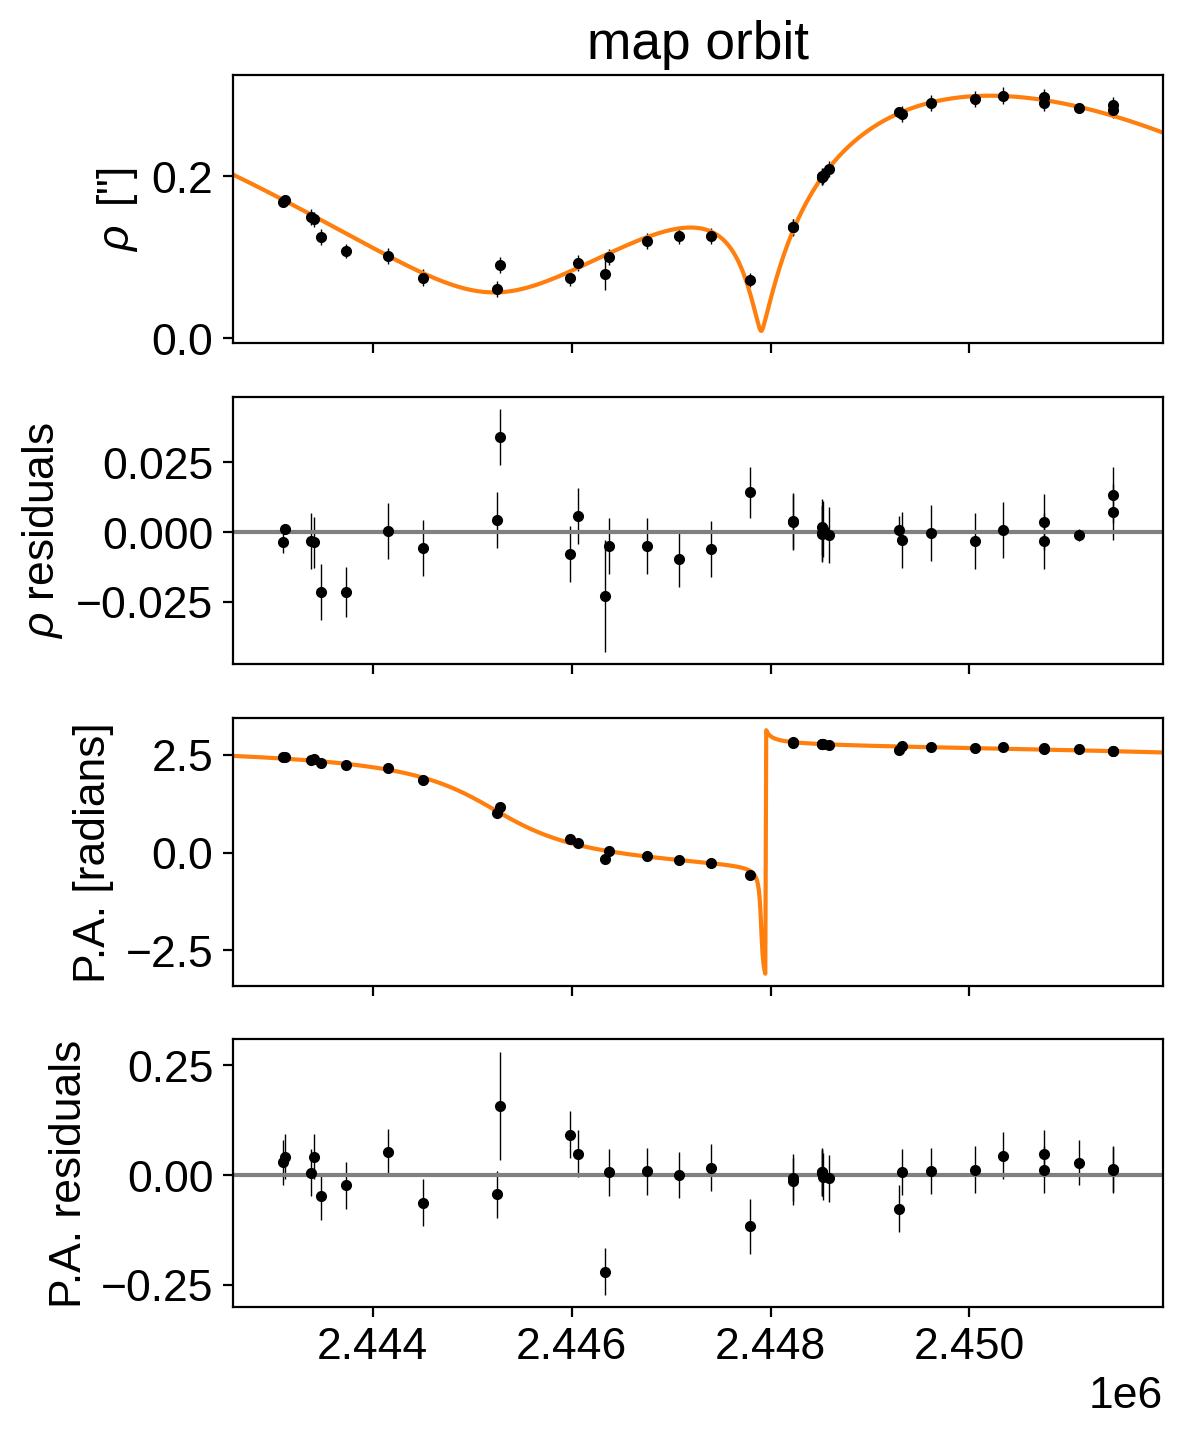

In [9]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    astro_jds, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw
)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    astro_jds, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

Now let's sample the posterior.

In [10]:
np.random.seed(1234)
with model:
    trace = pm.sample(
        tune=5000,
        draws=4000,
        start=map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9, adaptation_window=201),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


Sampling 2 chains for 5_000 tune and 4_000 draw iterations (10_000 + 8_000 draws total) took 88 seconds.


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


First we can check the convergence for some of the key parameters.

In [11]:
pm.summary(
    trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,10395.097,139.394,10172.919,10675.906,8.751,6.253,254.0,249.0,413.0,155.0,1.0
tperi,2447860.943,20.289,2447822.998,2447899.007,0.463,0.328,1918.0,1918.0,1906.0,2173.0,1.0
a_ang,0.318,0.008,0.304,0.334,0.000,0.000,1182.0,1158.0,1332.0,574.0,1.0
omega,1.235,0.014,1.209,1.262,0.000,0.000,1409.0,1409.0,1561.0,970.0,1.0
Omega,2.787,0.011,2.766,2.808,0.000,0.000,1231.0,1229.0,1231.0,1884.0,1.0
incl,1.691,0.006,1.679,1.703,0.000,0.000,1262.0,1262.0,1275.0,1238.0,1.0
ecc,0.776,0.012,0.755,0.801,0.000,0.000,880.0,867.0,925.0,581.0,1.0


That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

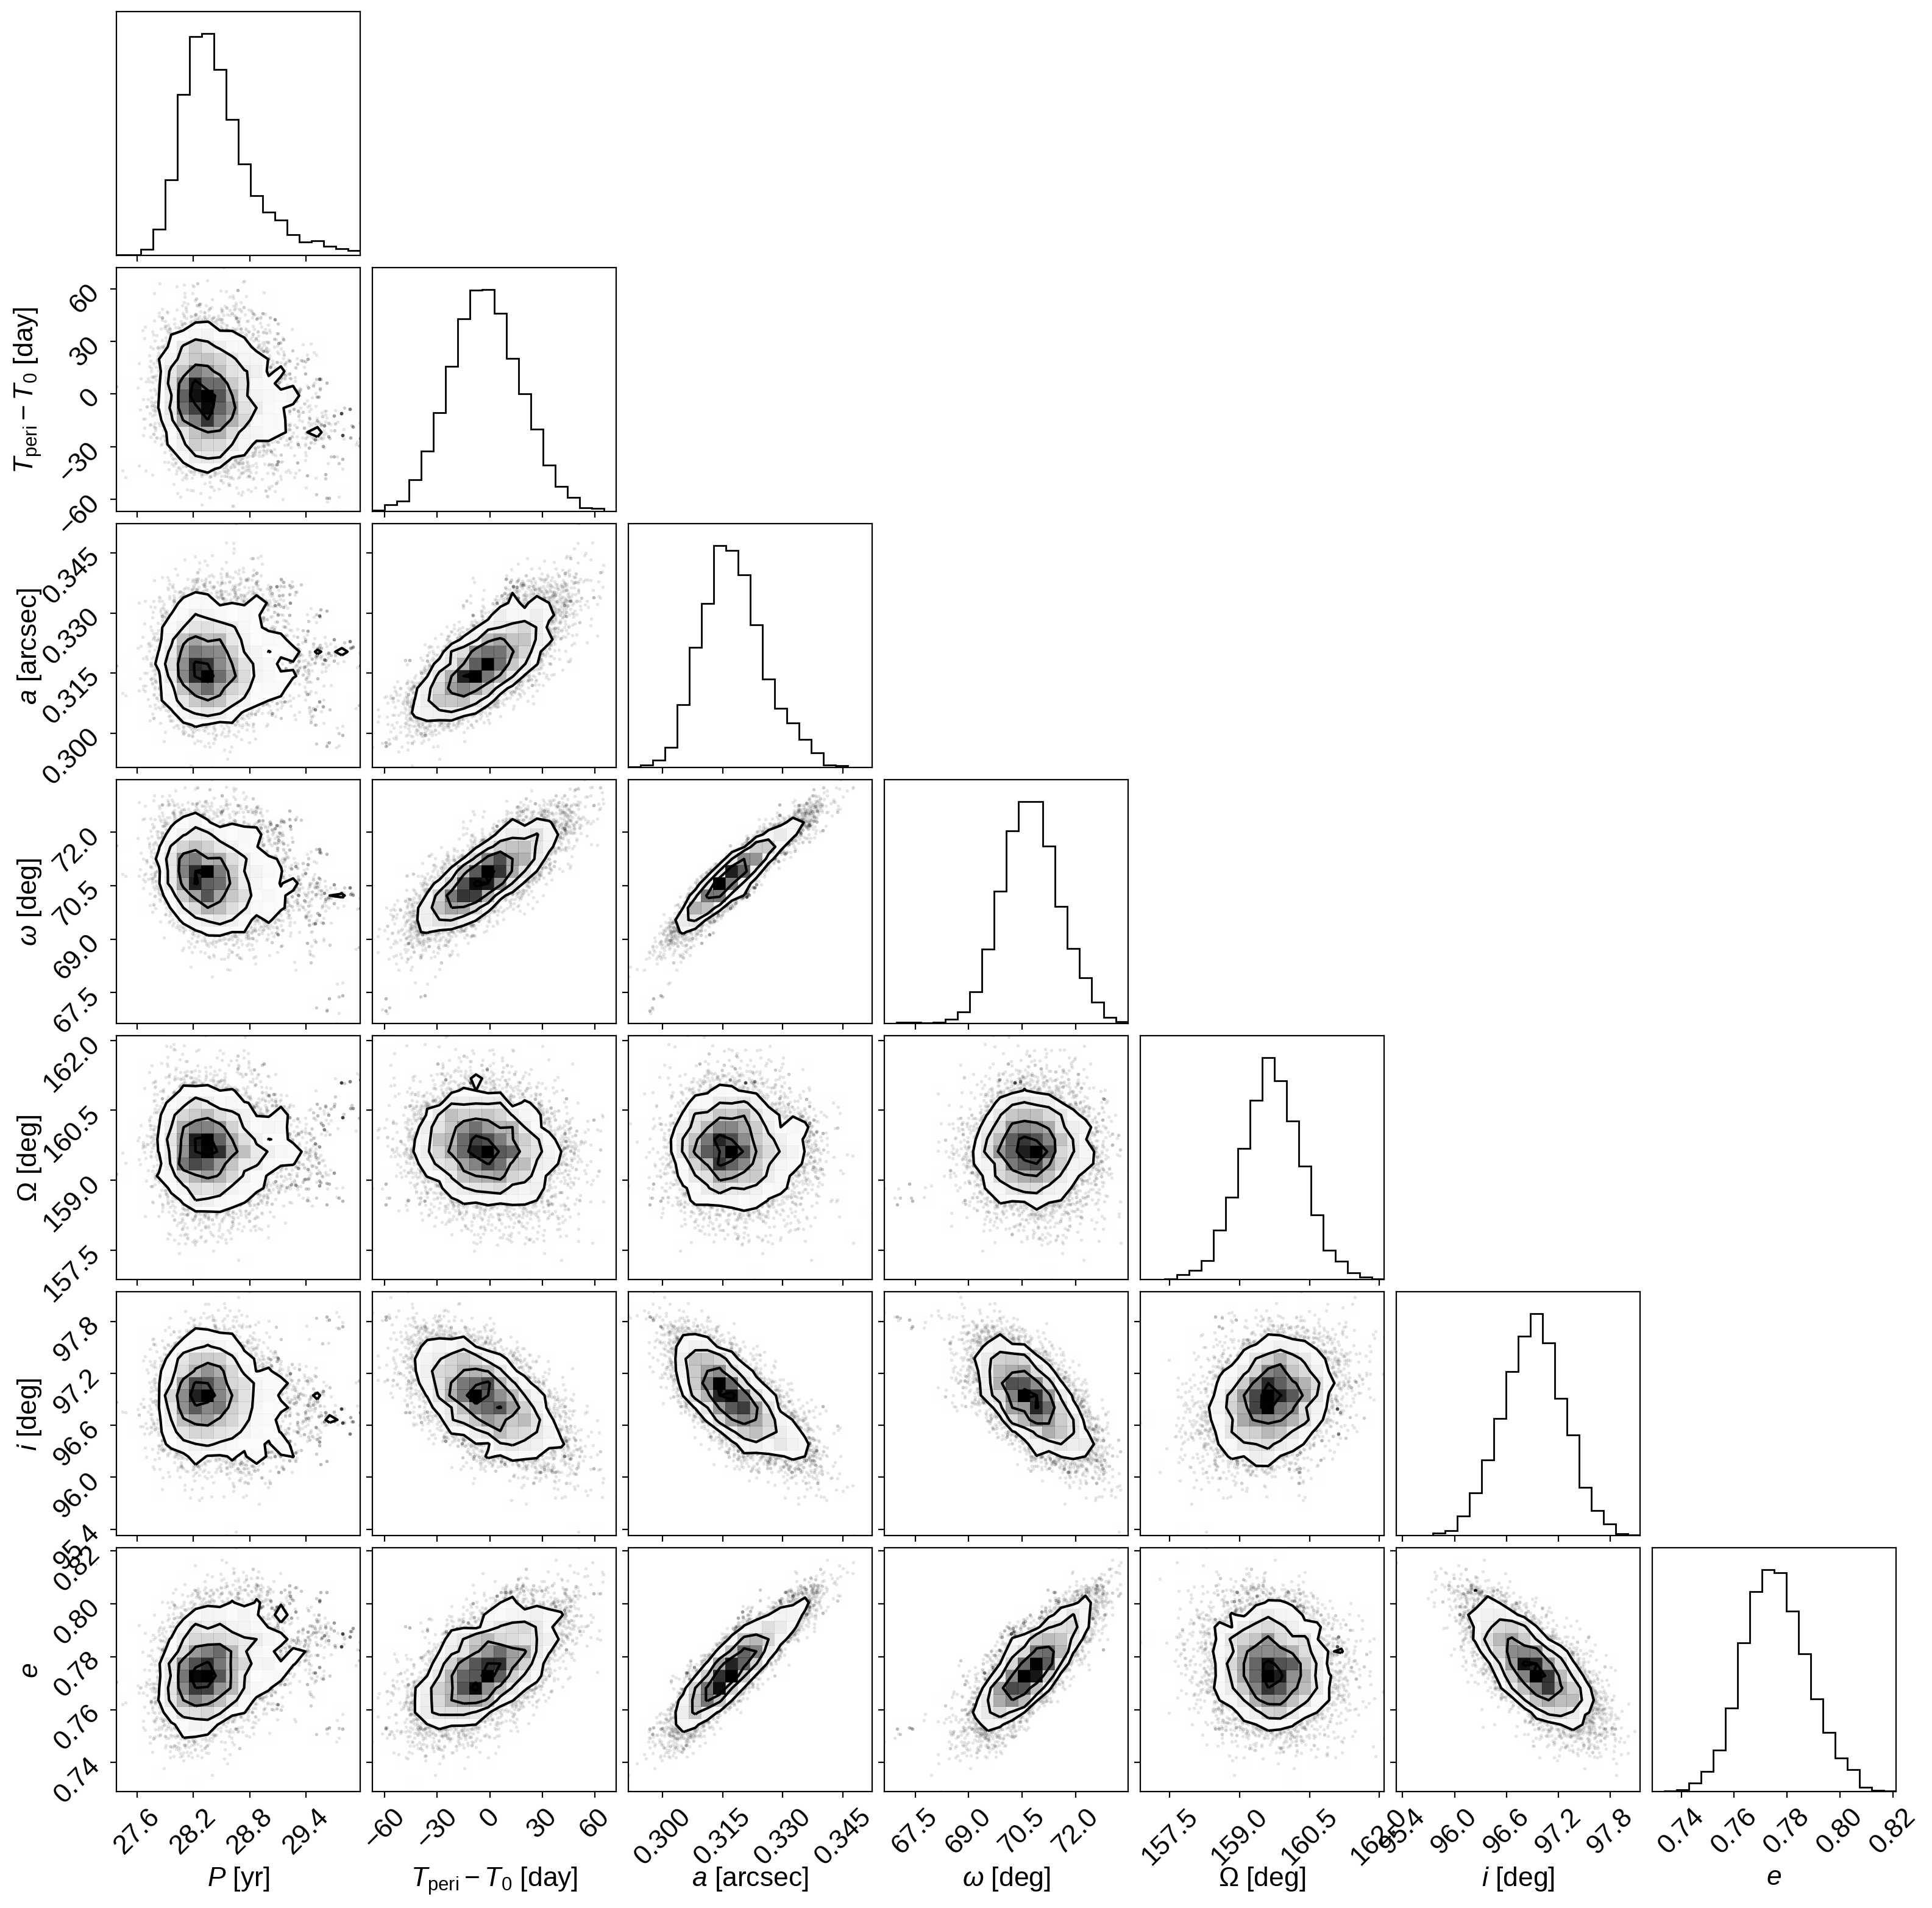

In [12]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["ecc"])
samples["$P$ [yr]"] = trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = trace["tperi"] - T0
samples["$a$ [arcsec]"] = trace["a_ang"]
samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
samples["$e$"] = samples["ecc"]
del samples["ecc"]
_ = corner.corner(samples)

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

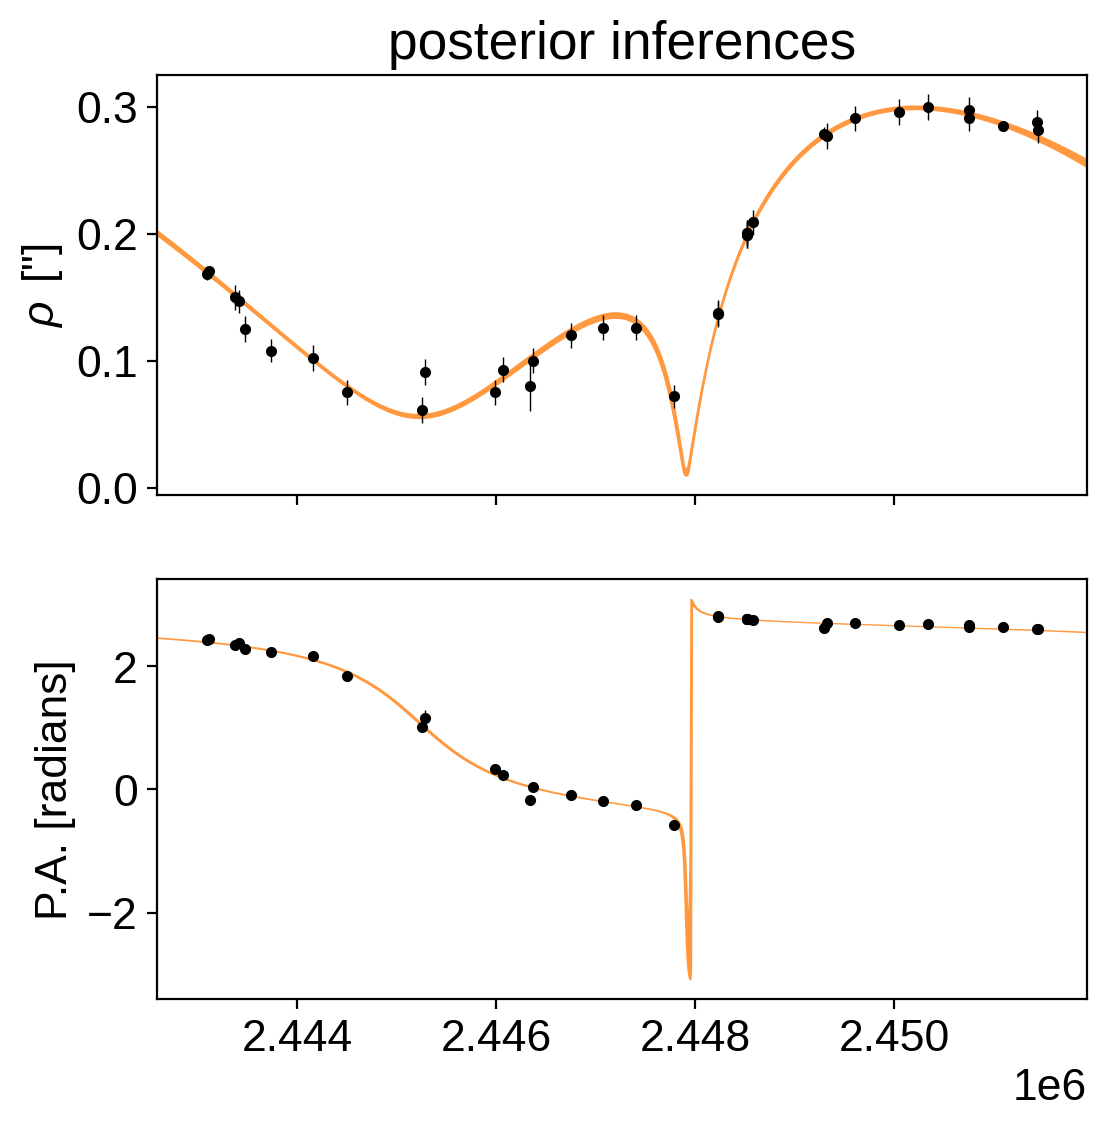

In [13]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"P.A. [radians]")

tot_rho_err = np.sqrt(
    rho_err ** 2 + np.exp(2 * np.median(trace["log_rho_s"], axis=0))
)
tot_theta_err = np.sqrt(
    theta_err ** 2 + np.exp(2 * np.median(trace["log_theta_s"], axis=0))
)

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace["rho_save"], [16, 84], axis=0)
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace["theta_save"], [16, 84], axis=0)
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("posterior inferences")

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry.
We also see two outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit.
It's likely the uncertainties were not estimated correctly for these, and the simlplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points.

## Including parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truely intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem.

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.

We can use exactly the same model as above with only an added parallax constraint:

In [14]:
plx_model, plx_map_soln = get_model(parallax=[24.05, 0.45])

optimizing logp for variables: [log_theta_s, log_rho_s]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.076402e+02]

1it [00:00, 495.02it/s, logp=1.076402e+02]

2it [00:00, 614.01it/s, logp=1.476711e+02]

3it [00:00, 622.85it/s, logp=1.084303e+02]

4it [00:00, 709.07it/s, logp=1.485840e+02]

5it [00:00, 749.44it/s, logp=1.497845e+02]

6it [00:00, 789.02it/s, logp=1.499280e+02]

7it [00:00, 821.52it/s, logp=1.499286e+02]

8it [00:00, 800.86it/s, logp=1.499286e+02]

9it [00:00, 815.77it/s, logp=1.499286e+02]

10it [00:01,  5.45it/s, logp=1.499286e+02]


message: Optimization terminated successfully.
logp: 107.64015029566296 -> 149.92860106267193


optimizing logp for variables: [phase]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.499286e+02]

1it [00:00, 547.63it/s, logp=1.499286e+02]

2it [00:00, 580.89it/s, logp=-1.185553e+04]

3it [00:00, 663.38it/s, logp=1.499517e+02] 

4it [00:00, 723.84it/s, logp=1.499982e+02]

5it [00:00, 787.28it/s, logp=1.501832e+02]

6it [00:00, 838.39it/s, logp=1.509035e+02]

7it [00:00, 880.10it/s, logp=1.535077e+02]

8it [00:00, 894.40it/s, logp=1.593811e+02]

9it [00:00, 908.03it/s, logp=1.662757e+02]

10it [00:00, 855.46it/s, logp=1.694242e+02]

11it [00:00, 869.68it/s, logp=1.703302e+02]

12it [00:00, 879.82it/s, logp=1.704061e+02]

13it [00:00, 891.46it/s, logp=1.704094e+02]

14it [00:00, 902.00it/s, logp=1.704128e+02]

15it [00:00, 910.38it/s, logp=1.704184e+02]

16it [00:00, 878.60it/s, logp=1.704249e+02]

17it [00:00, 881.16it/s, logp=1.704265e+02]

18it [00:00, 877.43it/s, logp=1.704268e+02]

19it [00:00, 884.35it/s, logp=1.704268e+02]

20it [00:00, 880.05it/s, logp=1.704268e+02]

21it [00:00, 879.99it/s, logp=1.704268e+02]

22it [00:00, 28.32it/s, logp=1.704268e+02] 


message: Optimization terminated successfully.
logp: 149.92860106267193 -> 170.4268151845905


optimizing logp for variables: [ecc, m, p]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.704268e+02]

1it [00:00, 416.39it/s, logp=1.704268e+02]

2it [00:00, 538.35it/s, logp=-4.518236e+03]

3it [00:00, 624.25it/s, logp=1.710200e+02] 

4it [00:00, 657.59it/s, logp=1.695336e+02]

5it [00:00, 705.21it/s, logp=1.711520e+02]

6it [00:00, 727.78it/s, logp=1.714066e+02]

7it [00:00, 761.24it/s, logp=1.721879e+02]

8it [00:00, 769.65it/s, logp=1.742150e+02]

9it [00:00, 783.20it/s, logp=1.812157e+02]

10it [00:00, 798.25it/s, logp=1.949820e+02]

11it [00:00, 812.05it/s, logp=1.964691e+02]

12it [00:00, 823.93it/s, logp=1.992100e+02]

13it [00:00, 762.25it/s, logp=2.038785e+02]

14it [00:00, 769.70it/s, logp=2.102587e+02]

15it [00:00, 777.64it/s, logp=2.122110e+02]

16it [00:00, 784.64it/s, logp=2.126408e+02]

17it [00:00, 773.31it/s, logp=2.126846e+02]

18it [00:00, 780.71it/s, logp=2.126998e+02]

19it [00:00, 787.45it/s, logp=2.127263e+02]

20it [00:00, 790.07it/s, logp=2.127699e+02]

21it [00:00, 794.49it/s, logp=2.128244e+02]

22it [00:00, 800.34it/s, logp=2.128398e+02]

23it [00:00, 792.16it/s, logp=2.128456e+02]

24it [00:00, 796.82it/s, logp=2.128460e+02]

25it [00:00, 801.89it/s, logp=2.128463e+02]

26it [00:00, 807.09it/s, logp=2.128468e+02]

27it [00:00, 786.80it/s, logp=2.128475e+02]

28it [00:00, 791.62it/s, logp=2.128479e+02]

29it [00:00, 794.09it/s, logp=2.128480e+02]

30it [00:00, 797.88it/s, logp=2.128480e+02]

31it [00:00, 801.23it/s, logp=2.128480e+02]

32it [00:00, 804.50it/s, logp=2.128480e+02]

33it [00:00, 794.05it/s, logp=2.128480e+02]

34it [00:00, 42.66it/s, logp=2.128480e+02] 


message: Optimization terminated successfully.
logp: 170.42681518459054 -> 212.8480158855976


optimizing logp for variables: [phase, a_ang, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.128480e+02]

1it [00:00, 510.75it/s, logp=2.128480e+02]

2it [00:00, 595.95it/s, logp=-4.375386e+03]

3it [00:00, 685.05it/s, logp=2.129960e+02] 

4it [00:00, 684.70it/s, logp=2.131453e+02]

5it [00:00, 722.26it/s, logp=2.132729e+02]

6it [00:00, 721.39it/s, logp=2.132857e+02]

7it [00:00, 746.37it/s, logp=2.132857e+02]

8it [00:00, 775.41it/s, logp=2.132860e+02]

9it [00:00, 770.60it/s, logp=2.132860e+02]

10it [00:00, 782.30it/s, logp=2.132860e+02]

11it [00:01,  8.97it/s, logp=2.132860e+02] 


message: Optimization terminated successfully.
logp: 212.8480158855976 -> 213.28597909410882


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.132860e+02]

1it [00:00, 344.76it/s, logp=2.132860e+02]

2it [00:00, 446.73it/s, logp=-4.038433e+03]

3it [00:00, 505.60it/s, logp=2.152474e+02] 

4it [00:00, 544.77it/s, logp=1.676432e+02]

5it [00:00, 586.27it/s, logp=2.153207e+02]

6it [00:00, 608.94it/s, logp=2.154316e+02]

7it [00:00, 621.42it/s, logp=2.156115e+02]

8it [00:00, 628.22it/s, logp=2.158705e+02]

9it [00:00, 641.55it/s, logp=2.160160e+02]

10it [00:00, 660.81it/s, logp=2.158620e+02]

11it [00:00, 685.34it/s, logp=2.160652e+02]

12it [00:00, 684.15it/s, logp=2.160890e+02]

13it [00:00, 688.22it/s, logp=2.161353e+02]

14it [00:00, 702.19it/s, logp=2.162848e+02]

15it [00:00, 703.36it/s, logp=2.166196e+02]

16it [00:00, 711.86it/s, logp=2.171740e+02]

17it [00:00, 719.34it/s, logp=2.175761e+02]

18it [00:00, 722.93it/s, logp=2.174845e+02]

19it [00:00, 732.21it/s, logp=2.176565e+02]

20it [00:00, 731.25it/s, logp=2.177043e+02]

21it [00:00, 730.12it/s, logp=2.177335e+02]

22it [00:00, 729.43it/s, logp=2.177622e+02]

23it [00:00, 723.13it/s, logp=2.177547e+02]

24it [00:00, 726.16it/s, logp=2.177767e+02]

25it [00:00, 726.71it/s, logp=2.177873e+02]

26it [00:00, 724.14it/s, logp=2.177936e+02]

27it [00:00, 726.73it/s, logp=2.178014e+02]

28it [00:00, 728.59it/s, logp=2.178034e+02]

29it [00:00, 729.93it/s, logp=2.178054e+02]

30it [00:00, 731.37it/s, logp=2.178058e+02]

31it [00:00, 724.14it/s, logp=2.178059e+02]

32it [00:00, 722.18it/s, logp=2.178059e+02]

33it [00:00, 722.76it/s, logp=2.178059e+02]

34it [00:00, 721.80it/s, logp=2.178059e+02]

35it [00:00, 722.65it/s, logp=2.178059e+02]

36it [00:00, 722.81it/s, logp=2.178059e+02]

37it [00:00, 724.82it/s, logp=2.178059e+02]

38it [00:00, 726.49it/s, logp=2.178059e+02]

39it [00:00, 731.21it/s, logp=2.178059e+02]

40it [00:00, 728.97it/s, logp=2.178059e+02]

41it [00:00, 732.71it/s, logp=2.178059e+02]

42it [00:00, 731.34it/s, logp=2.178059e+02]

43it [00:00, 732.67it/s, logp=2.178059e+02]

44it [00:00, 733.02it/s, logp=2.178059e+02]

45it [00:00, 736.21it/s, logp=2.178059e+02]

46it [00:00, 739.09it/s, logp=2.178059e+02]

47it [00:00, 737.65it/s, logp=2.178059e+02]

48it [00:00, 736.93it/s, logp=2.178059e+02]

49it [00:00, 739.99it/s, logp=2.178059e+02]

50it [00:00, 729.66it/s, logp=2.178059e+02]

51it [00:00, 727.62it/s, logp=2.178059e+02]

52it [00:00, 729.25it/s, logp=2.178059e+02]

53it [00:00, 729.57it/s, logp=2.178059e+02]

54it [00:00, 726.57it/s, logp=2.178059e+02]

55it [00:00, 726.31it/s, logp=2.178059e+02]

56it [00:00, 728.41it/s, logp=2.178059e+02]

57it [00:00, 732.07it/s, logp=2.178059e+02]

58it [00:00, 734.70it/s, logp=2.178059e+02]

59it [00:00, 723.24it/s, logp=2.178059e+02]

60it [00:00, 722.56it/s, logp=2.178059e+02]

61it [00:00, 724.28it/s, logp=2.178059e+02]

62it [00:00, 727.32it/s, logp=2.178059e+02]

63it [00:00, 729.96it/s, logp=2.178059e+02]

64it [00:00, 727.37it/s, logp=2.178059e+02]

65it [00:00, 729.70it/s, logp=2.178059e+02]

66it [00:00, 727.51it/s, logp=2.178059e+02]

67it [00:00, 724.28it/s, logp=2.178059e+02]

68it [00:00, 721.92it/s, logp=2.178059e+02]

69it [00:00, 724.38it/s, logp=2.178059e+02]

70it [00:00, 720.89it/s, logp=2.178059e+02]

71it [00:00, 723.55it/s, logp=2.178059e+02]

72it [00:00, 725.18it/s, logp=2.178059e+02]

73it [00:00, 727.72it/s, logp=2.178059e+02]

73it [00:00, 727.72it/s, logp=2.178059e+02]

74it [00:00, 727.72it/s, logp=2.178059e+02]

75it [00:00, 727.72it/s, logp=2.178059e+02]

76it [00:00, 727.72it/s, logp=2.178059e+02]

77it [00:00, 727.72it/s, logp=2.178059e+02]

78it [00:00, 727.72it/s, logp=2.178059e+02]

79it [00:00, 727.72it/s, logp=2.178059e+02]

80it [00:00, 727.72it/s, logp=2.178059e+02]

81it [00:00, 727.72it/s, logp=2.178059e+02]

82it [00:00, 727.72it/s, logp=2.178059e+02]

83it [00:00, 727.72it/s, logp=2.178059e+02]

84it [00:00, 727.72it/s, logp=2.178059e+02]

85it [00:00, 727.72it/s, logp=2.178059e+02]

86it [00:00, 727.72it/s, logp=2.178059e+02]

87it [00:00, 727.72it/s, logp=2.178059e+02]

88it [00:00, 727.72it/s, logp=2.178059e+02]

89it [00:00, 727.72it/s, logp=2.178059e+02]

90it [00:00, 102.24it/s, logp=2.178059e+02]


message: Desired error not necessarily achieved due to precision loss.
logp: 213.28597909410882 -> 217.8058683350306


In [15]:
np.random.seed(5432)
with plx_model:
    plx_trace = pm.sample(
        tune=5000,
        draws=4000,
        start=plx_map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9, start=plx_map_soln),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 2 chains for 5_000 tune and 4_000 draw iterations (10_000 + 8_000 draws total) took 87 seconds.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Check the convergence diagnostics.

In [16]:
pm.summary(
    plx_trace,
    varnames=[
        "P",
        "tperi",
        "a_ang",
        "omega",
        "Omega",
        "incl",
        "ecc",
        "M_tot",
        "plx",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,10372.709,111.836,10180.501,10604.325,3.588,2.552,972.0,961.0,1282.0,563.0,1.0
tperi,2447861.111,19.993,2447825.757,2447900.466,0.356,0.252,3147.0,3147.0,3178.0,3963.0,1.0
a_ang,0.318,0.008,0.303,0.332,0.000,0.000,1072.0,1017.0,1623.0,926.0,1.0
omega,1.235,0.014,1.207,1.260,0.000,0.000,1554.0,1530.0,1769.0,971.0,1.0
Omega,2.787,0.012,2.765,2.809,0.000,0.000,4069.0,4067.0,4062.0,3651.0,1.0
incl,1.692,0.006,1.680,1.704,0.000,0.000,1348.0,1348.0,1611.0,962.0,1.0
ecc,0.775,0.012,0.753,0.798,0.000,0.000,1121.0,1090.0,1415.0,843.0,1.0
M_tot,2.872,0.281,2.366,3.412,0.007,0.006,1498.0,1244.0,2168.0,1116.0,1.0
plx,0.024,0.000,0.023,0.025,0.000,0.000,5354.0,5354.0,5352.0,4842.0,1.0


And make the corner plot for the physical parameters.

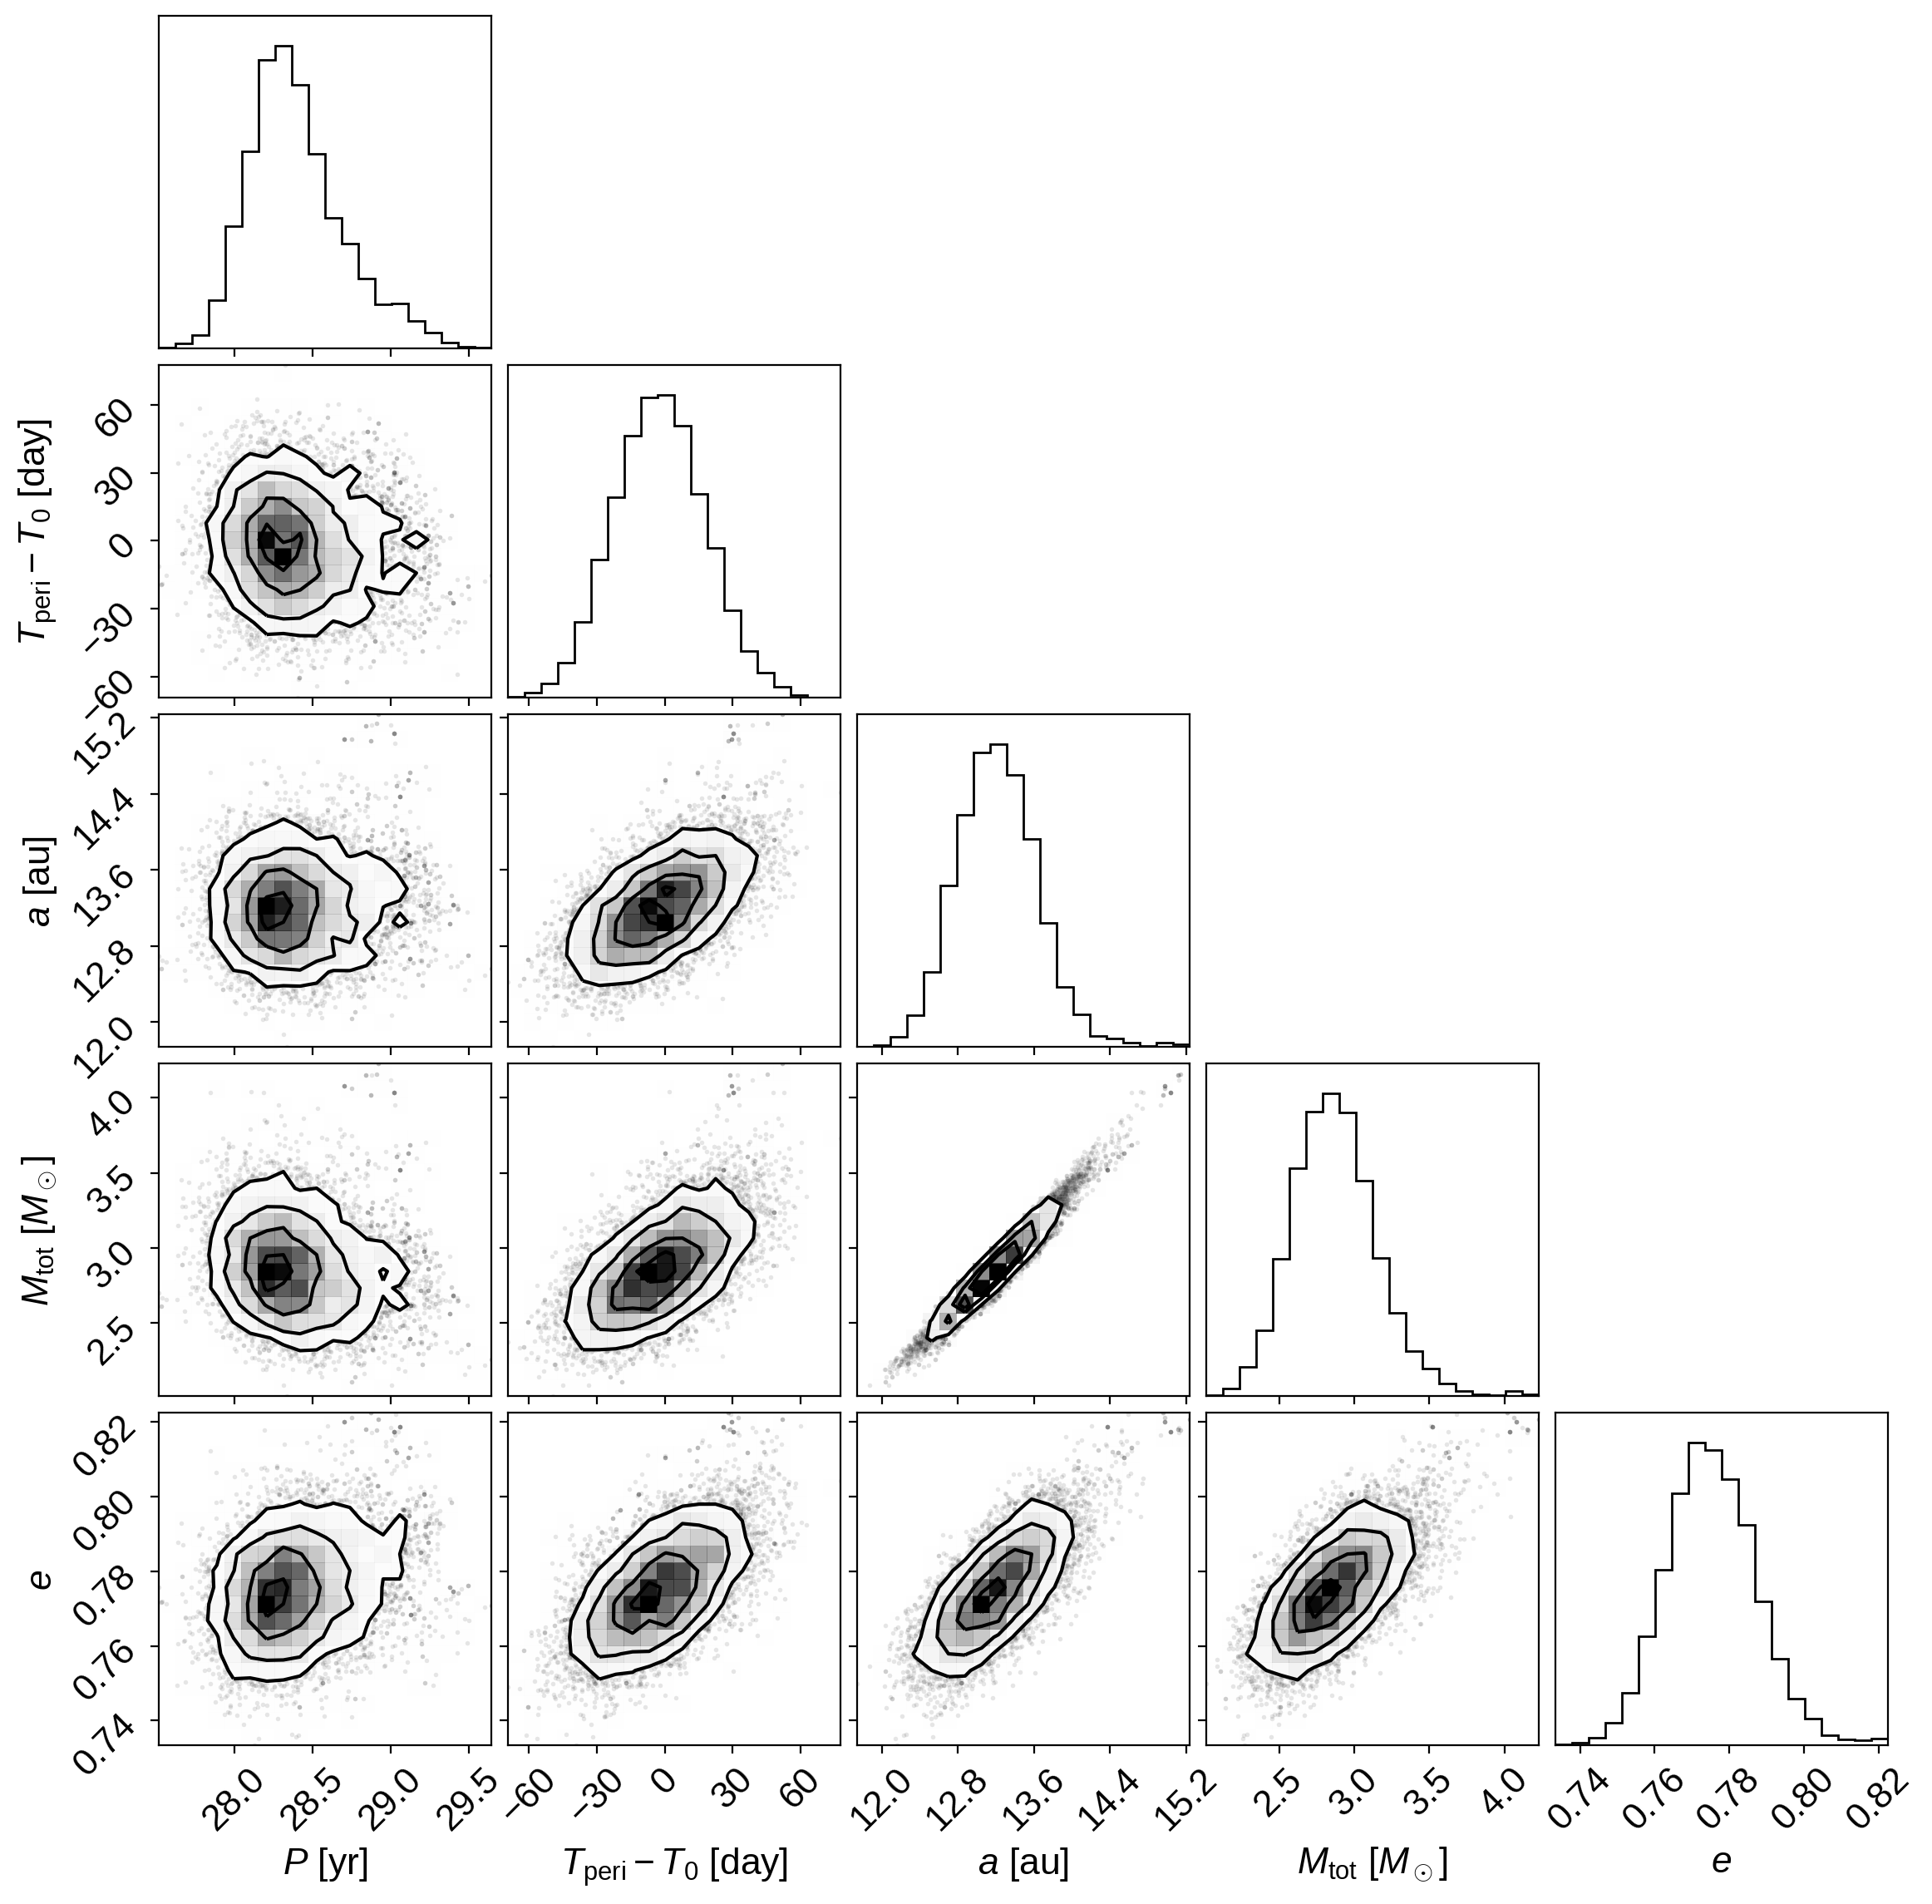

In [17]:
samples = pm.trace_to_dataframe(plx_trace, varnames=["ecc"])
samples["$P$ [yr]"] = plx_trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = plx_trace["tperi"] - T0
samples["$a$ [au]"] = plx_trace["a"]
samples["$M_\mathrm{tot}$ [$M_\odot$]"] = plx_trace["M_tot"]
samples["$e$"] = plx_trace["ecc"]
del samples["ecc"]
_ = corner.corner(samples)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [18]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [19]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
